In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e2/sample_submission.csv
/kaggle/input/playground-series-s5e2/train.csv
/kaggle/input/playground-series-s5e2/test.csv
/kaggle/input/playground-series-s5e2/training_extra.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor


In [3]:
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor

In [4]:
train= pd.read_csv('/kaggle/input/playground-series-s5e2/train.csv', index_col='id')
train.head()

,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price
id,,,,,,,,,,
0,Jansport,Leather,Medium,7.0,Yes,No,Tote,Black,11.611723,112.15875
1,Jansport,Canvas,Small,10.0,Yes,Yes,Messenger,Green,27.078537,68.88056
2,Under Armour,Leather,Small,2.0,Yes,No,Messenger,Red,16.643760,39.17320
3,Nike,Nylon,Small,8.0,Yes,No,Messenger,Green,12.937220,80.60793
4,Adidas,Canvas,Medium,1.0,Yes,Yes,Messenger,Green,17.749338,86.02312


In [5]:
train_extra= pd.read_csv('/kaggle/input/playground-series-s5e2/training_extra.csv',index_col='id')
train_extra.head()

,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price
id,,,,,,,,,,
500000,Under Armour,Canvas,Small,10.0,Yes,Yes,Tote,Blue,23.882052,114.11068
500001,Puma,Polyester,Small,4.0,No,Yes,Backpack,Green,11.869095,129.74972
500002,Jansport,Polyester,Small,8.0,Yes,Yes,Tote,Red,8.092302,21.37370
500003,Nike,Nylon,Large,7.0,No,No,Messenger,Pink,7.719581,48.09209
500004,Nike,Leather,Large,9.0,No,Yes,Tote,Green,22.741826,77.32461


In [6]:
train= pd.concat([train, train_extra],ignore_index= True)

In [7]:
train.shape

(3994318, 10)

In [8]:
train.columns

Index(['Brand', 'Material', 'Size', 'Compartments', 'Laptop Compartment',
       'Waterproof', 'Style', 'Color', 'Weight Capacity (kg)', 'Price'],
      dtype='object')

In [9]:
train

,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price
0,Jansport,Leather,Medium,7.0,Yes,No,Tote,Black,11.611723,112.15875
1,Jansport,Canvas,Small,10.0,Yes,Yes,Messenger,Green,27.078537,68.88056
2,Under Armour,Leather,Small,2.0,Yes,No,Messenger,Red,16.643760,39.17320
3,Nike,Nylon,Small,8.0,Yes,No,Messenger,Green,12.937220,80.60793
4,Adidas,Canvas,Medium,1.0,Yes,Yes,Messenger,Green,17.749338,86.02312
...,...,...,...,...,...,...,...,...,...,...
3994313,Nike,Canvas,NaN,3.0,Yes,Yes,Messenger,Blue,28.098120,104.74460
3994314,Puma,Leather,Small,10.0,Yes,Yes,Tote,Blue,17.379531,122.39043
3994315,Jansport,Canvas,Large,10.0,No,No,Backpack,Red,17.037708,148.18470
3994316,Puma,Canvas,NaN,2.0,No,No,Backpack,Gray,28.783339,22.32269


In [10]:
train.dtypes

Brand                    object
Material                 object
Size                     object
Compartments            float64
Laptop Compartment       object
Waterproof               object
Style                    object
Color                    object
Weight Capacity (kg)    float64
Price                   float64
dtype: object

In [11]:
null_vals=train.isna().sum()
null_vals

Brand                   126758
Material                110962
Size                     87785
Compartments                 0
Laptop Compartment       98533
Waterproof               94324
Style                   104180
Color                   133617
Weight Capacity (kg)      1808
Price                        0
dtype: int64

In [12]:
null_vals.shape[0]

10

In [13]:
columns= train.columns
for i in range(null_vals.shape[0]):
    print(f"{columns[i]}: Null percentage{round(null_vals[i]/train.shape[0],5)}")

Brand: Null percentage0.03173
Material: Null percentage0.02778
Size: Null percentage0.02198
Compartments: Null percentage0.0
Laptop Compartment: Null percentage0.02467
Waterproof: Null percentage0.02361
Style: Null percentage0.02608
Color: Null percentage0.03345
Weight Capacity (kg): Null percentage0.00045
Price: Null percentage0.0


<ipython-input-13-dc3bbdc8e3e8>:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"{columns[i]}: Null percentage{round(null_vals[i]/train.shape[0],5)}")


In [14]:
columns

Index(['Brand', 'Material', 'Size', 'Compartments', 'Laptop Compartment',
       'Waterproof', 'Style', 'Color', 'Weight Capacity (kg)', 'Price'],
      dtype='object')

In [15]:
def fill_na_values(train):
    for col in ['Brand', 'Material', 'Size', 'Laptop Compartment','Waterproof', 'Style', 'Color']:
        train[col] = train[col].fillna('Not Specified')
    
    for col in ['Weight Capacity (kg)','Compartments']:
        train[col] = train[col].fillna(train[col].median())

    return train

In [16]:
train= fill_na_values(train)

In [17]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3994318 entries, 0 to 3994317
Data columns (total 10 columns):
 #   Column                Dtype  
---  ------                -----  
 0   Brand                 object 
 1   Material              object 
 2   Size                  object 
 3   Compartments          float64
 4   Laptop Compartment    object 
 5   Waterproof            object 
 6   Style                 object 
 7   Color                 object 
 8   Weight Capacity (kg)  float64
 9   Price                 float64
dtypes: float64(3), object(7)
memory usage: 304.7+ MB


In [18]:
pd.options.display.float_format = '{:.2f}'.format
train.describe()

,Compartments,Weight Capacity (kg),Price
count,3994318.00,3994318.00,3994318.00
mean,5.43,18.01,81.36
std,2.89,6.97,38.94
min,1.00,5.00,15.00
25%,3.00,12.07,47.47
50%,5.00,18.05,80.98
75%,8.00,23.99,114.86
max,10.00,30.00,150.00


In [19]:
for col in columns:
    if train[col].dtype=='object':
        print(train[col].value_counts(),'\n\n')
        

Brand
Under Armour     801035
Adidas           797000
Nike             764407
Puma             755778
Jansport         749340
Not Specified    126758
Name: count, dtype: int64 


Material
Polyester        1060882
Leather           976186
Nylon             942656
Canvas            903632
Not Specified     110962
Name: count, dtype: int64 


Size
Medium           1354487
Large            1312295
Small            1239751
Not Specified      87785
Name: count, dtype: int64 


Laptop Compartment
Yes              1972937
No               1922848
Not Specified      98533
Name: count, dtype: int64 


Waterproof
Yes              1969205
No               1930789
Not Specified      94324
Name: count, dtype: int64 


Style
Messenger        1329677
Tote             1297942
Backpack         1262519
Not Specified     104180
Name: count, dtype: int64 


Color
Pink             688257
Gray             666110
Blue             638485
Red              630215
Black            620610
Green            617024
N

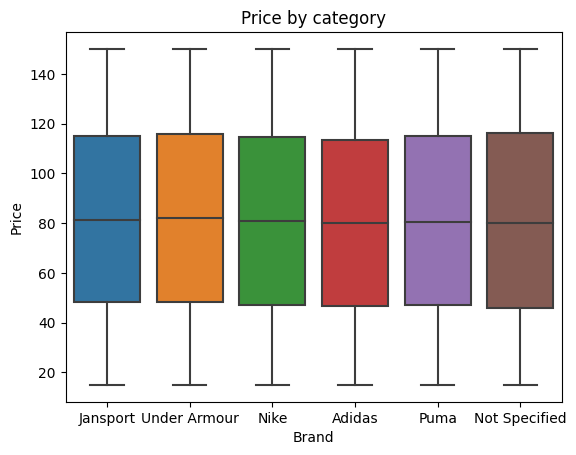

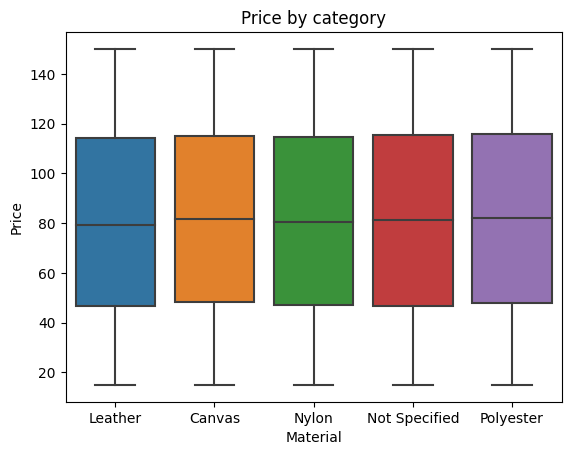

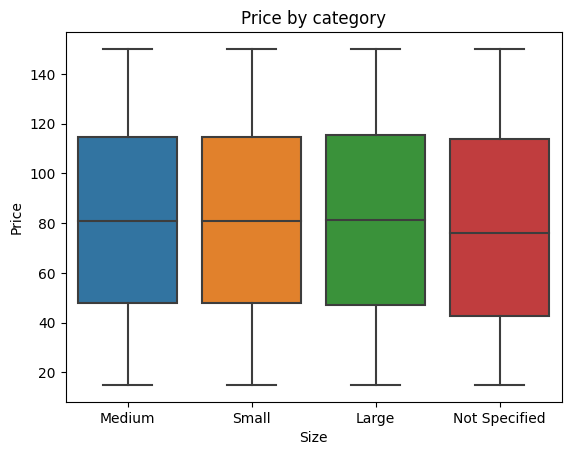

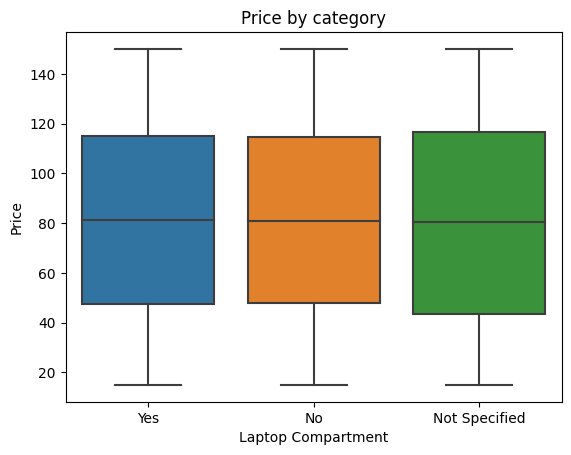

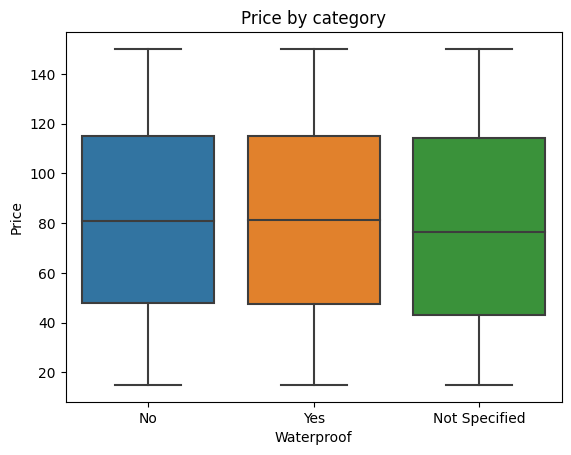

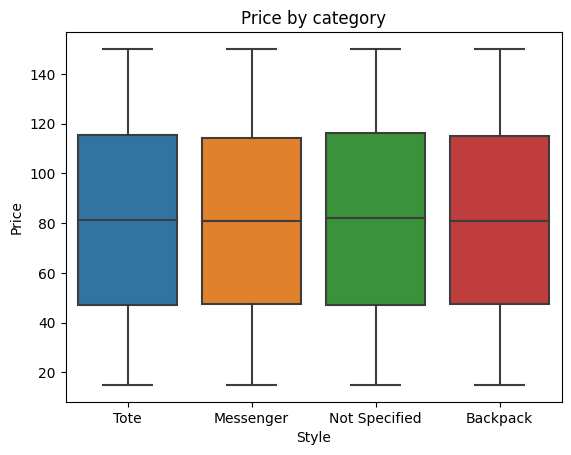

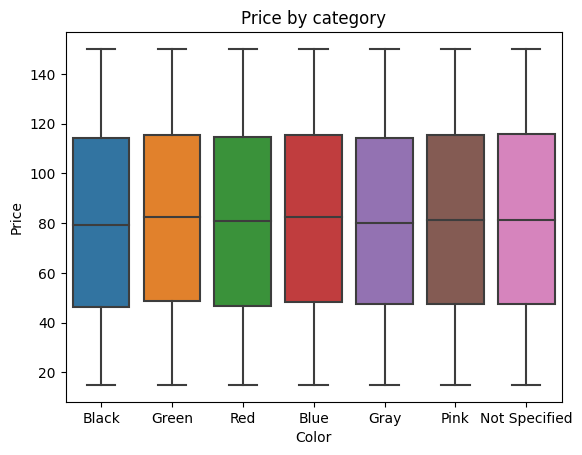

In [20]:
for col in train.columns:
    if train[col].dtype =='object':
        sns.boxplot(x=col, y="Price", data=train)
        plt.title("Price by category")
        plt.show()

In [21]:
num_cols= [col for col in train.columns if train[col].dtype=='float64']
train[num_cols].corr()

,Compartments,Weight Capacity (kg),Price
Compartments,1.00,0.00,-0.00
Weight Capacity (kg),0.00,1.00,0.02
Price,-0.00,0.02,1.00


In [22]:
columns

Index(['Brand', 'Material', 'Size', 'Compartments', 'Laptop Compartment',
       'Waterproof', 'Style', 'Color', 'Weight Capacity (kg)', 'Price'],
      dtype='object')

In [23]:
train['Size'].value_counts()

Size
Medium           1354487
Large            1312295
Small            1239751
Not Specified      87785
Name: count, dtype: int64

In [24]:
def encode_cat_cols(train):
    # Encode Size
    size_map={
        "Medium":3,           
        "Large":4,        
        "Small":2,   
        "Not Specified":1
    }
    
    train['Size']=  train['Size'].map(size_map)

    # Encode Laptop Compartment
    lc_map= {
        "Yes":1,
        "No":0,
        "Not Specified":0
    }
    train['Laptop Compartment']=  train['Laptop Compartment'].map(lc_map)

    #Encode Watrtproof
    train['Waterproof']=  train['Waterproof'].map(lc_map)
    
    
    cat_cols= ['Brand', 'Material', 'Style', 'Color']
    for col in cat_cols:
        dummies = pd.get_dummies(train[col])
        if 'Not Specified' in dummies.columns:
            dummies= dummies.drop(['Not Specified'], axis='columns')
        train= pd.concat([train,dummies],axis='columns')
        train= train.drop([col], axis='columns')

    return train

In [25]:
train= encode_cat_cols(train)

In [26]:
train.dtypes

Size                      int64
Compartments            float64
Laptop Compartment        int64
Waterproof                int64
Weight Capacity (kg)    float64
Price                   float64
Adidas                     bool
Jansport                   bool
Nike                       bool
Puma                       bool
Under Armour               bool
Canvas                     bool
Leather                    bool
Nylon                      bool
Polyester                  bool
Backpack                   bool
Messenger                  bool
Tote                       bool
Black                      bool
Blue                       bool
Gray                       bool
Green                      bool
Pink                       bool
Red                        bool
dtype: object

In [27]:
X= train.drop('Price',axis='columns')
Y= train.Price

In [28]:
X.dtypes

Size                      int64
Compartments            float64
Laptop Compartment        int64
Waterproof                int64
Weight Capacity (kg)    float64
Adidas                     bool
Jansport                   bool
Nike                       bool
Puma                       bool
Under Armour               bool
Canvas                     bool
Leather                    bool
Nylon                      bool
Polyester                  bool
Backpack                   bool
Messenger                  bool
Tote                       bool
Black                      bool
Blue                       bool
Gray                       bool
Green                      bool
Pink                       bool
Red                        bool
dtype: object

In [29]:
def check_model(model_name):
    # Initialize KFold with 5 splits
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    # Create a regression model
    model = model_name
    
    # Evaluate the model using negative mean squared error as the scoring metric
    scores = cross_val_score(model, X, Y, cv=kf, scoring='mean_squared_error')
    
    print("K-Fold CV Scores (Negative MSE):", scores)
    print("Average Score:", np.mean(scores))
    

In [30]:


gbr = GradientBoostingRegressor(learning_rate=0.05, n_estimators=200,alpha=0.8, subsample=1.0, random_state=42)
gbr.fit(X, Y)


GradientBoostingRegressor(alpha=0.8, learning_rate=0.05, n_estimators=200,
                          random_state=42)

In [31]:
test= pd.read_csv('/kaggle/input/playground-series-s5e2/test.csv', index_col='id')
test.isna().sum()

Brand                   6227
Material                5613
Size                    4381
Compartments               0
Laptop Compartment      4962
Waterproof              4811
Style                   5153
Color                   6785
Weight Capacity (kg)      77
dtype: int64

In [32]:
test= fill_na_values(test)

In [33]:
test= encode_cat_cols(test)

In [34]:
y=gbr.predict(test)

In [35]:
y

array([81.31068524, 82.98201022, 81.88607661, ..., 82.62205299,
       81.67140078, 81.75196313])

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Density'>

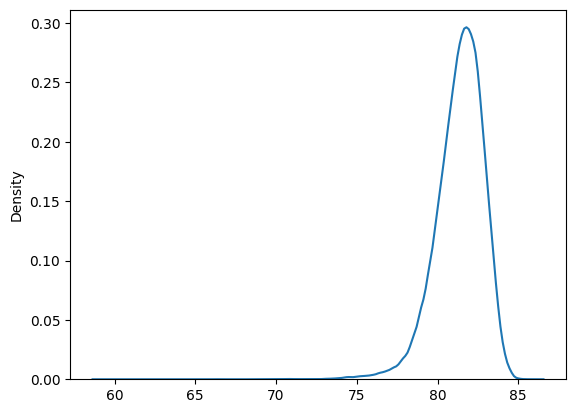

In [36]:
sns.kdeplot(y)

In [37]:
test['Price']=y

In [38]:
sub= test[['Price']]
sub

,Price
id,
300000,81.31
300001,82.98
300002,81.89
300003,81.41
300004,79.73
...,...
499995,79.61
499996,77.76
499997,82.62


In [39]:
sub.to_csv('submission.csv')